In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt

from scipy import stats
from os import listdir
from tensorflow.python.client import device_lib
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Bidirectional, LeakyReLU, Dense, Dropout, Input, Convolution1D, Layer,Flatten, Reshape
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import regularizers, initializers, constraints
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from keras.utils import plot_model
random_seed = 34
batch_size = 16
epochs = 100

In [38]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1511729398830458938
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9220039639
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12030231064553252042
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [39]:
class PharmacophoreException(Exception):
    pass

class PharmacophoreFileEndException(PharmacophoreException):
    pass

class PharmacophorePoint(object):
    def __init__(self, code, cx, cy, cz, alpha, norm, nx, ny, nz):
        self.code = code
        self.cx = float(cx)
        self.cy = float(cy)
        self.cz = float(cz)
        self.alpha = float(alpha)
        self.norm = int(norm)
        self.nx = float(nx)
        self.ny = float(ny)
        self.nz = float(nz)
    
    @classmethod
    def from_line(cls, line):
        return cls(*line.split())
    
    def to_line(self):
        return "{} {} {} {} {} {} {} {} {}".format(self.code, self.cx, self.cy, self.cz, self.alpha, self.norm,\
                                                self.nx, self.ny, self.nz)
    
    def __str__(self):
        return self.to_line()
        
    
    
class Pharmacophore(object):
    def __init__(self, name, points):
        self.name = name
        self.points = points
        
    @classmethod
    def from_stream(cls, stream):
        name = stream.readline().strip()
        points = []
        line = stream.readline().strip()
        if not line:
            raise PharmacophoreFileEndException("End of file")
            
        while line != "$$$$" or not line:
            points.append(PharmacophorePoint.from_line(line))
            line = stream.readline().strip()
            
        if not line:
            raise PharmacophoreException("Wrong format, no end line")
        return cls(name, points)
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as fd:
            return cls.from_stream(fd)
            
    def write_to_stream(self, stream):
        stream.write("{}\n".format(self.name))
        for point in self.points:
            stream.write("{}\n".format(point.to_line()))
        stream.write("$$$$\n".format(self.name))
            
    def write_to_file(self, file_path):
        with open(file_path, "w") as fd:
            self.write_to_stream(fd)
            
    def __str__(self):
        return  "{}\n{}\n$$$$".format(self.name,
                                      "\n".join(str(x) for x in self.points))
    
    def __len__(self):
        return len(self.points)
    
    def sample(self, name, n):
        points = sample(self.points, min(n, len(self)))
        return Pharmacophore(name, points)

class PharmDatabaseException(Exception):
    pass


def calc_pharmacophore(lig_path, ph_path):
    proc = Popen(
        "align-it --dbase {} --pharmacophore {}".format(lig_path, ph_path),
        shell=True,
        stdout=PIPE, stderr=PIPE)
    _ = proc.communicate()
    

class PharmDatabase(object):
    def __init__(self, path_to_ligands, path_to_ph_db, is_calculated=False):
        self.path_to_ligands = path_to_ligands
        self.path_to_ph_db = path_to_ph_db
        self.is_calculated = is_calculated
    
    def repair_database(self):
        pass
    
    def calc_database(self):
        if not self.path_to_ph_db:
            self.calc_pharmacophore(self.path_to_ligands, self.path_to_ph_db)

    
    def sample_database(self):
        pass
    
    def iter_database(self):
        if not self.is_calculated:
            raise PharmDatabaseException("Not calculated")
        with open(self.path_to_ph_db, 'r') as fd:
            while True:
                try:
                    pharmacophore = Pharmacophore.from_stream(fd)
                    yield pharmacophore
                except PharmacophoreFileEndException:
                    break
    

In [40]:
from rdkit import Chem
from rdkit.Chem import AllChem
def smi_to_morganfingerprint(smi, radius, MORGAN_SIZE):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        tempReturn = np.zeros(MORGAN_SIZE, dtype=np.int8)
        vec = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=MORGAN_SIZE)
        for i in range(tempReturn.shape[0]):
            tempReturn[i] = vec[i]   
        return tempReturn
    else:
        return np.zeros(MORGAN_SIZE)
    

In [41]:
def get_fasta(fasta_name, training_data):
    training_data['sequence'] = None
    file = open(fasta_name)
    index = 0
    seq = ''
    for line in file: 
        if line.startswith(">"):
            if index >= 1:
                training_data['sequence'][training_data['target_id'] == name] = seq                
                print(index,name,seq[:10])
            seq = ''
            name = line[4:10]
            index = index + 1
            
        else:
            seq = seq + line[:-1]
    return training_data

# Data Prepreprocessing

In [124]:
training_data = pd.read_csv('PDR_SMILES.csv')
training_data.head()

,PPDB Ref no,Pesticide,Chemical Name (CAS),CAS RN,Plant,Scientific name,Study location,Matrix,IN or ON matrix,Field or Undercover,Min (days),Max (days),Mean (days),SMILES
0,4,"2,4-D","(2,4-dichlorophenoxy)acetic acid",94-75-7,Bromegrass,Bromus spp.,"NY, USA",Blades,O,F,3.0,3.0,3.00,OC(=O)COc1ccc(Cl)cc1Cl
1,4,"2,4-D","(2,4-dichlorophenoxy)acetic acid",94-75-7,Kentucky bluegrass,Poa pratensis L.,Canada,Thatch,I,F,1.0,39.6,24.80,OC(=O)COc1ccc(Cl)cc1Cl
2,4,"2,4-D","(2,4-dichlorophenoxy)acetic acid",94-75-7,Kentucky bluegrass,Poa pratensis L.,"Iowa, USA",Thatch,I,F,2.7,3.6,3.15,OC(=O)COc1ccc(Cl)cc1Cl
3,4,"2,4-D","(2,4-dichlorophenoxy)acetic acid",94-75-7,Orchard grass,*,"NY, USA",Blades,O,F,2.4,2.4,2.40,OC(=O)COc1ccc(Cl)cc1Cl
4,4,"2,4-D","(2,4-dichlorophenoxy)acetic acid",94-75-7,Timothy grass,Phleum pratense,"NY, USA",Blades,O,F,1.1,1.1,1.10,OC(=O)COc1ccc(Cl)cc1Cl


In [125]:
# ,'Scientific name'
data3 = pd.read_csv("PDR_SMILES.csv")
# data3[data3 == '*'] = np.nan
data3 = pd.concat([data3[data3['IN or ON matrix'] == 'O'], data3[data3['IN or ON matrix'] == 'I']])
data3 = pd.concat([data3[data3['Field or Undercover'] == 'F'], data3[data3['Field or Undercover'] == 'U']])
data4 = data3[['Plant','Scientific name','Study location','Matrix','IN or ON matrix','Field or Undercover','SMILES','Min (days)','Max (days)','Mean (days)']].copy()
remained_index = data4[['Plant','Scientific name','Study location','Matrix','IN or ON matrix','Field or Undercover','SMILES']].drop_duplicates(keep = False ).index
Data_properties = data4[['Plant','Scientific name','Study location','Matrix','IN or ON matrix','Field or Undercover']].loc[remained_index]
smiles = data4['SMILES'].loc[remained_index]
Target_properties = data4[['Min (days)','Max (days)','Mean (days)']].loc[remained_index]
data5 = Data_properties.copy()
# data5["Type"] = data5["IN or ON matrix"].map(str) + data5["Field or Undercover"].map(str)
# types = np.argmax(pd.get_dummies(data5['Type']).values,axis = 1)
types = data4['Mean (days)'].loc[remained_index].copy()
types = types.astype('int32').copy()
types[types <16] = 0  
types2 = types.copy()
types2[types2 >= 60] = 0
types[types2 !=0] = 1
types[types >= 60] = 2 
types.shape

(2247,)

In [126]:
radius = 6 
MORGAN_SIZE = 2048
SMILES_MORGAN = np.zeros((smiles.shape[0], MORGAN_SIZE), dtype=np.int8)
for ind, smi in enumerate(smiles):
    SMILES_MORGAN[ind] = smi_to_morganfingerprint(smi, radius, MORGAN_SIZE)
# SMILES_MORGAN[SMILES_MORGAN == 0] = -1
SMILES_MORGAN.shape

(2247, 2048)

In [159]:
Data_properties['Study location'].unique()

array(['NY, USA', 'TX, USA', 'CA, USA', 'China', 'India', 'AZ, USA',
       'USA', 'Australia', 'UK', 'Italy', 'Greece', '*', 'California USA',
       'Florida, USA', 'LA, USA', 'West Africa', 'Egypt', 'VT, USA',
       'FL, USA', 'Canada', 'Netherlands', 'Guam', 'Taiwan', 'MA, USA',
       'Pakistan', 'KY, USA', 'IA, USA', 'GA, USA', 'California, USA',
       'Spain', 'Belgium', 'MS, USA', 'New Zealand', 'Czechoslovakia ',
       'IL, USA', 'OR, USA', 'England', 'Japan', 'Saudi arabia', 'France',
       'DC, USA', 'Brazil', 'WA, USA', 'Republic of Korea', 'Egypy',
       'Poland', 'Syria', 'DE, USA', 'South Africa', 'Fl, USA', 'VA, USA',
       'UT, USA', 'South africa', 'Iowa, USA', 'Serbia', 'Chile', 'nd',
       'Between Yemen and Saudi Arabia', 'NC, USA', 'WI, USA', 'Columbia',
       'Zimbabwe', 'MD, USA', 'Saudi Arabia', 'IN, USA', 'Costa Rica',
       'Malaysia', 'KS, USA', 'Hungary', 'AR, USA', 'IL, ISA', 'china',
       'Iran', 'Venezuela', 'Ga, USA', 'Portugal', 'Canda', 'NE

In [128]:
np.save("PDR_SMILES_MORGAN_2048_6.npy", SMILES_MORGAN)

In [129]:
np.save("PDR_Target_properties.npy", Target_properties.values)

In [130]:
np.save("PDR_types.npy", types)

In [131]:
Data_properties.head()

,Plant,Scientific name,Study location,Matrix,IN or ON matrix,Field or Undercover
0,Bromegrass,Bromus spp.,"NY, USA",Blades,O,F
3,Orchard grass,*,"NY, USA",Blades,O,F
4,Timothy grass,Phleum pratense,"NY, USA",Blades,O,F
15,Cotton,Gossypium hirsutum L.,"TX, USA",Leaves,O,F
18,Grapefruit,Citrus ¡Ñ paradisi,"CA, USA",Fruit,O,F


In [132]:
pd.get_dummies(Data_properties).head()

,Plant_Alder,Plant_Alfalfa,Plant_Amaranth,Plant_Amaranth (autumn),Plant_Amaranth (summer),Plant_Annual bluegrass,Plant_Annual ryegrass (Italian ),Plant_Apple,Plant_Apple,Plant_Apple (dwarf),...,Matrix_Tuber skin,Matrix_Turf,Matrix_Wax,Matrix_Whole fruit,Matrix_Whole plant,Matrix_straw,IN or ON matrix_I,IN or ON matrix_O,Field or Undercover_F,Field or Undercover_U
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [133]:
np.save("PDR_properties.npy", pd.get_dummies(Data_properties).values)

# Training

In [134]:
X_list = np.concatenate((np.load('PDR_SMILES_MORGAN_2048_6.npy'),np.load('PDR_properties.npy')),axis = -1)
# Y_list = np.log10(np.load('PDR_Target_properties.npy'))
Y_list = np.load('PDR_Target_properties.npy')

types = np.load('PDR_types.npy')
X_list.shape,Y_list.shape,types.shape

((2247, 3094), (2247, 3), (2247,))

In [135]:
for i in range(len(np.unique(types))):
    print(len(types[types == i]))

2100
128
19


In [136]:
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [137]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [138]:
def root_mean_squared_error_loss(y_true, y_pred):
    X = 10**(-y_pred)
    Y = 10**(-y_true)
    return K.sqrt(K.mean(K.square(X - Y)))

In [139]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs): 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform') 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer) 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint) 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint) 
            self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint) 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W) 
        if self.bias:
            uit += self.b 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u) 
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [140]:
from sklearn.model_selection import train_test_split
x_train_from_train, x_val_from_train, y_train_from_train, y_val_from_train = train_test_split(X_list, Y_list, test_size=0.2, random_state=random_seed, stratify = types)
x_train_from_train.shape, x_val_from_train.shape, y_train_from_train.shape, y_val_from_train.shape

((1797, 3094), (450, 3094), (1797, 3), (450, 3))

In [144]:
#model structure
model_name = 'ACTHON_model_2048_6'
auxiliary_input1 = Input(shape=(3094,), dtype='float32', name='main_input')
x = Dense(1524)(auxiliary_input1)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(768)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(384)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(192)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(96)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(48)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(24)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(12)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
r = Dropout(0.2)(x)
x = Dense(6)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dropout(0.2)(x)
main_output = Dense(3,activation='relu')(x)
model = Model(inputs=auxiliary_input1, outputs=main_output)
print(model.summary())

opt = keras.optimizers.Adam()
model.compile(loss=root_mean_squared_error,
              optimizer=opt,
              metrics=[pearson_r])
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3094)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1524)              4716780   
_________________________________________________________________
batch_normalization_46 (Batc (None, 1524)              6096      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 1524)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 768)               1171200   
_________________________________________________________________
batch_normalization_47 (Batc (None, 768)               3072      
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 768)               0         
__________

In [170]:
model_history = model.fit(x_train_from_train, np.log10(y_train_from_train),
                          batch_size=batch_size, epochs=100, verbose=1, callbacks=[checkpointer],
                         validation_data=(x_val_from_train, np.log10(y_val_from_train)), class_weight = 'auto')

Train on 1797 samples, validate on 450 samples
Epoch 1/100
1797/1797 [==============================] - 3s 2ms/step - loss: 4.3828 - pearson_r: 0.3693 - val_loss: 2.2005 - val_pearson_r: 0.3309

Epoch 00001: val_loss improved from 7.13809 to 2.20050, saving model to ACTHON_model_2048_6
Epoch 2/100
1797/1797 [==============================] - 3s 2ms/step - loss: 2.6239 - pearson_r: 0.1227 - val_loss: 1.5274 - val_pearson_r: 0.2289

Epoch 00002: val_loss improved from 2.20050 to 1.52735, saving model to ACTHON_model_2048_6
Epoch 3/100
1797/1797 [==============================] - 3s 2ms/step - loss: 1.8047 - pearson_r: 0.1488 - val_loss: 0.9538 - val_pearson_r: 0.2315

Epoch 00003: val_loss improved from 1.52735 to 0.95383, saving model to ACTHON_model_2048_6
Epoch 4/100
1797/1797 [==============================] - 4s 2ms/step - loss: 1.3735 - pearson_r: 0.2063 - val_loss: 0.6519 - val_pearson_r: 0.2394

Epoch 00004: val_loss improved from 0.95383 to 0.65185, saving model to ACTHON_model_


Epoch 00037: val_loss did not improve from 0.36917
Epoch 38/100
1797/1797 [==============================] - 2s 1ms/step - loss: 0.3232 - pearson_r: 0.7484 - val_loss: 0.3638 - val_pearson_r: 0.4804

Epoch 00038: val_loss improved from 0.36917 to 0.36384, saving model to ACTHON_model_2048_6
Epoch 39/100
1797/1797 [==============================] - 2s 1ms/step - loss: 0.3114 - pearson_r: 0.7605 - val_loss: 0.3780 - val_pearson_r: 0.4393

Epoch 00039: val_loss did not improve from 0.36384
Epoch 40/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.3079 - pearson_r: 0.7572 - val_loss: 0.3724 - val_pearson_r: 0.4471

Epoch 00040: val_loss did not improve from 0.36384
Epoch 41/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.3079 - pearson_r: 0.7646 - val_loss: 0.3707 - val_pearson_r: 0.4613

Epoch 00041: val_loss did not improve from 0.36384
Epoch 42/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.3079 - pearson_r: 0.7613 - 

1797/1797 [==============================] - 3s 2ms/step - loss: 0.2958 - pearson_r: 0.7801 - val_loss: 0.3640 - val_pearson_r: 0.4927

Epoch 00077: val_loss did not improve from 0.35086
Epoch 78/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2888 - pearson_r: 0.7873 - val_loss: 0.3665 - val_pearson_r: 0.4768

Epoch 00078: val_loss did not improve from 0.35086
Epoch 79/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2893 - pearson_r: 0.7990 - val_loss: 0.3641 - val_pearson_r: 0.4887

Epoch 00079: val_loss did not improve from 0.35086
Epoch 80/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2931 - pearson_r: 0.7897 - val_loss: 0.3673 - val_pearson_r: 0.4725

Epoch 00080: val_loss did not improve from 0.35086
Epoch 81/100
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2933 - pearson_r: 0.7768 - val_loss: 0.3665 - val_pearson_r: 0.4786

Epoch 00081: val_loss did not improve from 0.35086
Epoch 82/100


In [171]:
file = open(model_name+'_history.pickle', 'wb')
pickle.dump(model.history.history, file)
file.close()

In [194]:
"""
@author: Anna Cichonska
"""

import numpy as np
import copy
from math import sqrt
from scipy import stats
from sklearn import preprocessing,metrics




def rmse(y,f):
    """
    Task:    To compute root mean squared error (RMSE)

    Input:   y      Vector with original labels (pKd [M])
             f      Vector with predicted labels (pKd [M])

    Output:  rmse   RSME
    """

    rmse = sqrt(((y - f)**2).mean(axis=0))

    return rmse




def pearson(y,f):
    """
    Task:    To compute Pearson correlation coefficient

    Input:   y      Vector with original labels (pKd [M])
             f      Vector with predicted labels (pKd [M])

    Output:  rp     Pearson correlation coefficient
    """

    rp = np.corrcoef(y, f)[0,1]

    return rp




def spearman(y,f):
    """
    Task:    To compute Spearman's rank correlation coefficient

    Input:   y      Vector with original labels (pKd [M])
             f      Vector with predicted labels (pKd [M])

    Output:  rs     Spearman's rank correlation coefficient
    """

    rs = stats.spearmanr(y, f)[0]

    return rs




def ci(y,f):
    """
    Task:    To compute concordance index (CI)

    Input:   y      Vector with original labels (pKd [M])
             f      Vector with predicted labels (pKd [M])

    Output:  ci     CI

    References:
    [1] Tapio Pahikkala, Antti Airola, Sami Pietila, Sushil Shakyawar,
    Agnieszka Szwajda, JingTang and Tero Aittokallio.
    Toward more realistic drug-target interaction predictions.
    Briefings in Bioinformatics, 16, pages 325-337, 2014.
    """

    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]

    i = len(y)-1
    j = i-1
    z = 0.0
    S = 0.0

    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z+1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i-1

    ci = S/z

    return ci




def weighted_f1(y,f):
    """
    Task:    To compute F1 score using the threshold of 7 M
             to binarize pKd's into true class labels.

    Input:   y      Vector with original labels (pKd [M])
             f      Vector with predicted labels (pKd [M])
    Output:  f1     F1 score
    """

    
    
    y_binary = y.astype('int32').copy()
    y_binary[y_binary <16] = 0  
    y_binary2 = y_binary.copy()
    y_binary2[y_binary2 >= 60] = 0
    y_binary[y_binary2 !=0] = 1
    y_binary[y_binary >= 60] = 2 



    f_binary = f.astype('int32').copy()
    f_binary[f_binary <16] = 0  
    f_binary2 = f_binary.copy()
    f_binary2[f_binary2 >= 60] = 0
    f_binary[f_binary2 !=0] = 1
    f_binary[f_binary >= 60] = 2 
    f1 = metrics.f1_score(y_binary, f_binary, average='weighted')

    return f1




def average_AUC(y,f):

    thr = np.linspace(16,60,10)
    auc = np.empty(np.shape(thr)); auc[:] = np.nan

    for i in range(len(thr)):
        y_binary = copy.deepcopy(y)
        y_binary = preprocessing.binarize(y_binary.reshape(1,-1), threshold=thr[i], copy=False)[0]
        fpr, tpr, thresholds = metrics.roc_curve(y_binary, f, pos_label=1)
        auc[i] = metrics.auc(fpr, tpr)

    avAUC = np.mean(auc)
    
    
#     y_binary = y.astype('int32').copy()
#     y_binary[y_binary <16] = 0  
#     y_binary2 = y_binary.copy()
#     y_binary2[y_binary2 >= 60] = 0
#     y_binary[y_binary2 !=0] = 1
#     y_binary[y_binary >= 60] = 2 


#     f_binary = f.astype('int32').copy()
#     f_binary[f_binary <16] = 0  
#     f_binary2 = f_binary.copy()
#     f_binary2[f_binary2 >= 60] = 0
#     f_binary[f_binary2 !=0] = 1
#     f_binary[f_binary >= 60] = 2 
    
#     avAUC = 0
#     for i in range(3):
#         fpr, tpr, thresholds = metrics.roc_curve(y_binary, f_binary, pos_label=i)
#         avAUC = avAUC + metrics.auc(fpr, tpr)
#     avAUC = avAUC/3

    return avAUC

def accuracy(y,f):

    """
    Task:    To compute F1 score using the threshold of 7 M
             to binarize pKd's into true class labels.

    Input:   y      Vector with original labels (pKd [M])
             f      Vector with predicted labels (pKd [M])
    Output:  f1     F1 score
    """

    
    
    y_binary = y.astype('int32').copy()
    y_binary[y_binary <16] = 0  
    y_binary2 = y_binary.copy()
    y_binary2[y_binary2 >= 60] = 0
    y_binary[y_binary2 !=0] = 1
    y_binary[y_binary >= 60] = 2 



    f_binary = f.astype('int32').copy()
    f_binary[f_binary <16] = 0  
    f_binary2 = f_binary.copy()
    f_binary2[f_binary2 >= 60] = 0
    f_binary[f_binary2 !=0] = 1
    f_binary[f_binary >= 60] = 2 
    accuracy = metrics.accuracy_score(y_binary, f_binary)

    return accuracy

In [196]:
# reload a file to a variable
for i in range(10):
    with open(model_name+'_history.pickle', 'rb') as file:
        historyList = pickle.load(file)
%matplotlib inline

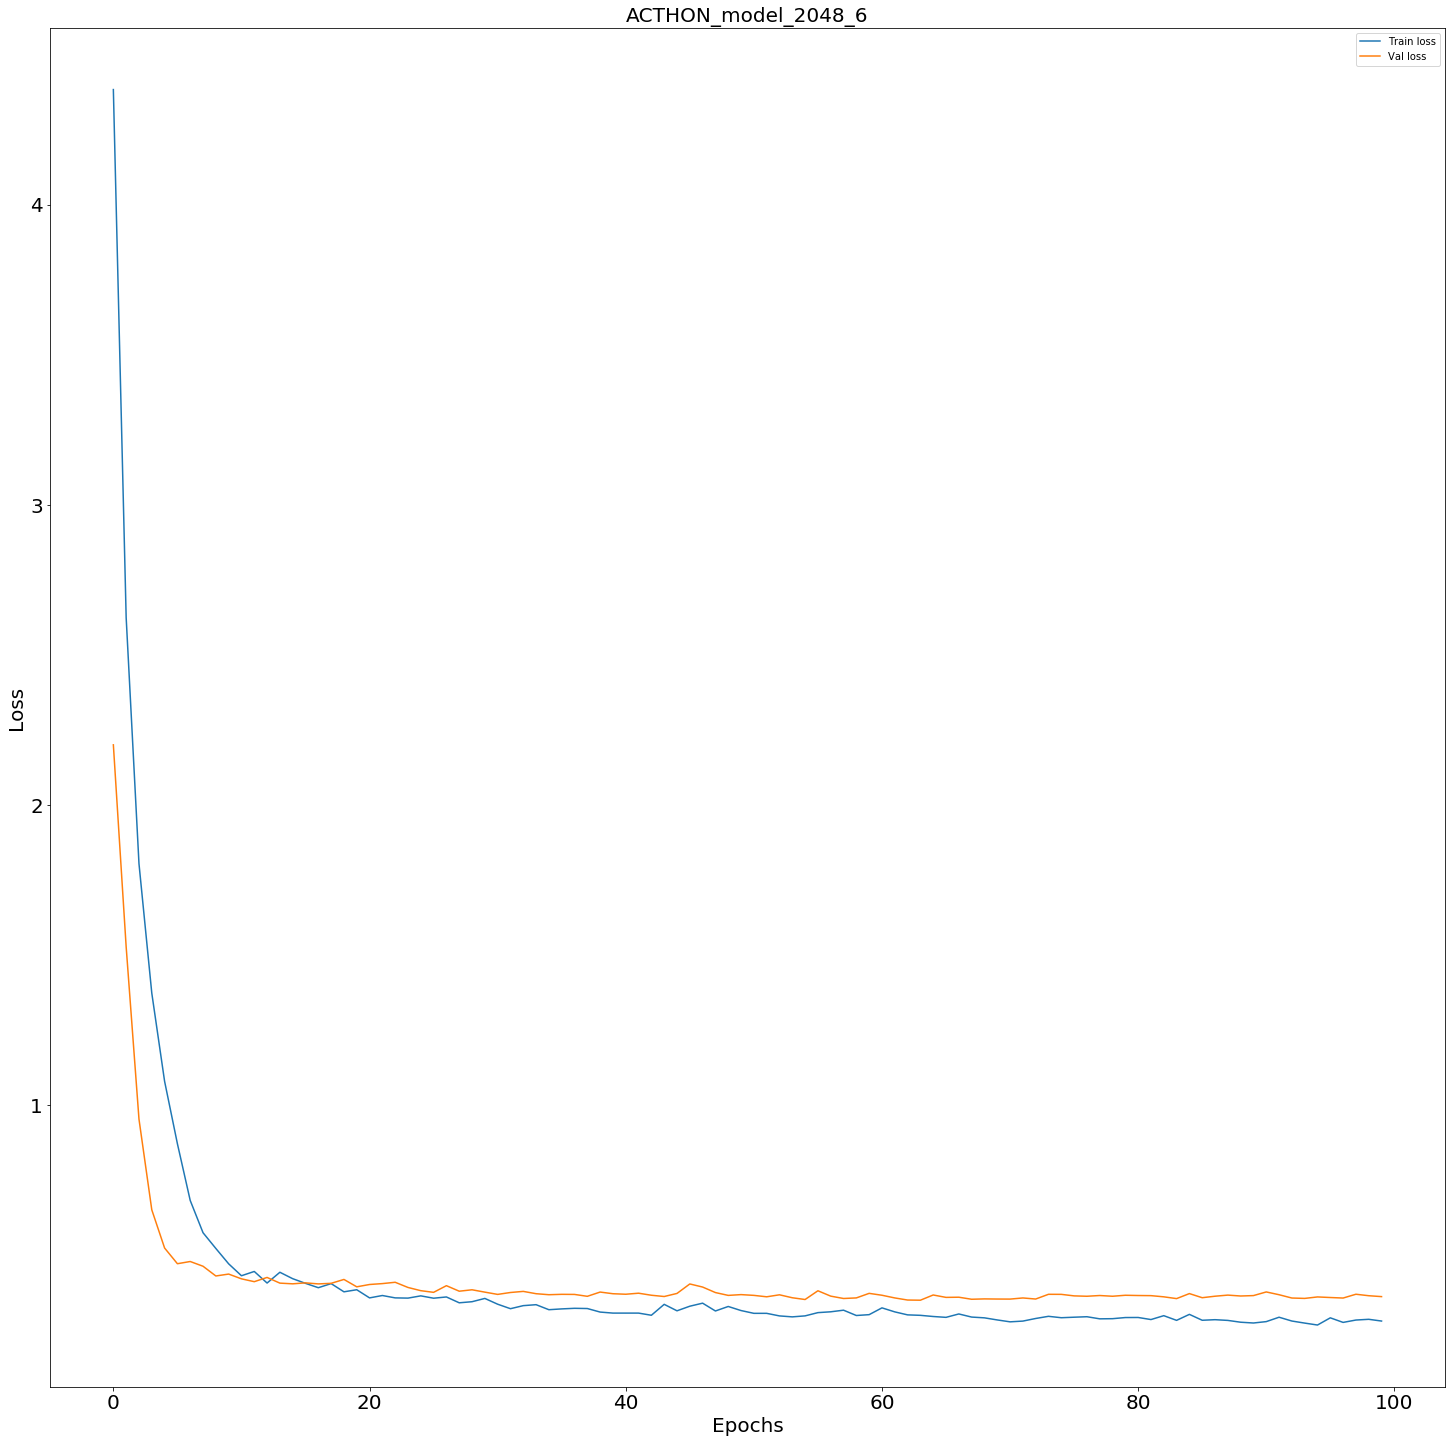

In [197]:
BIGGER_SIZE = 20
plt.figure(figsize=(25, 25))
plt.plot(historyList['loss'], label='Train loss')
plt.plot(historyList['val_loss'], label='Val loss')
plt.xlabel('Epochs', size=BIGGER_SIZE)
plt.ylabel('Loss', size=BIGGER_SIZE)
plt.xticks(fontsize=BIGGER_SIZE)
plt.yticks(fontsize=BIGGER_SIZE)
# plt.ylim((-0.1, 4)) 
plt.title(model_name, size=BIGGER_SIZE)
plt.legend()

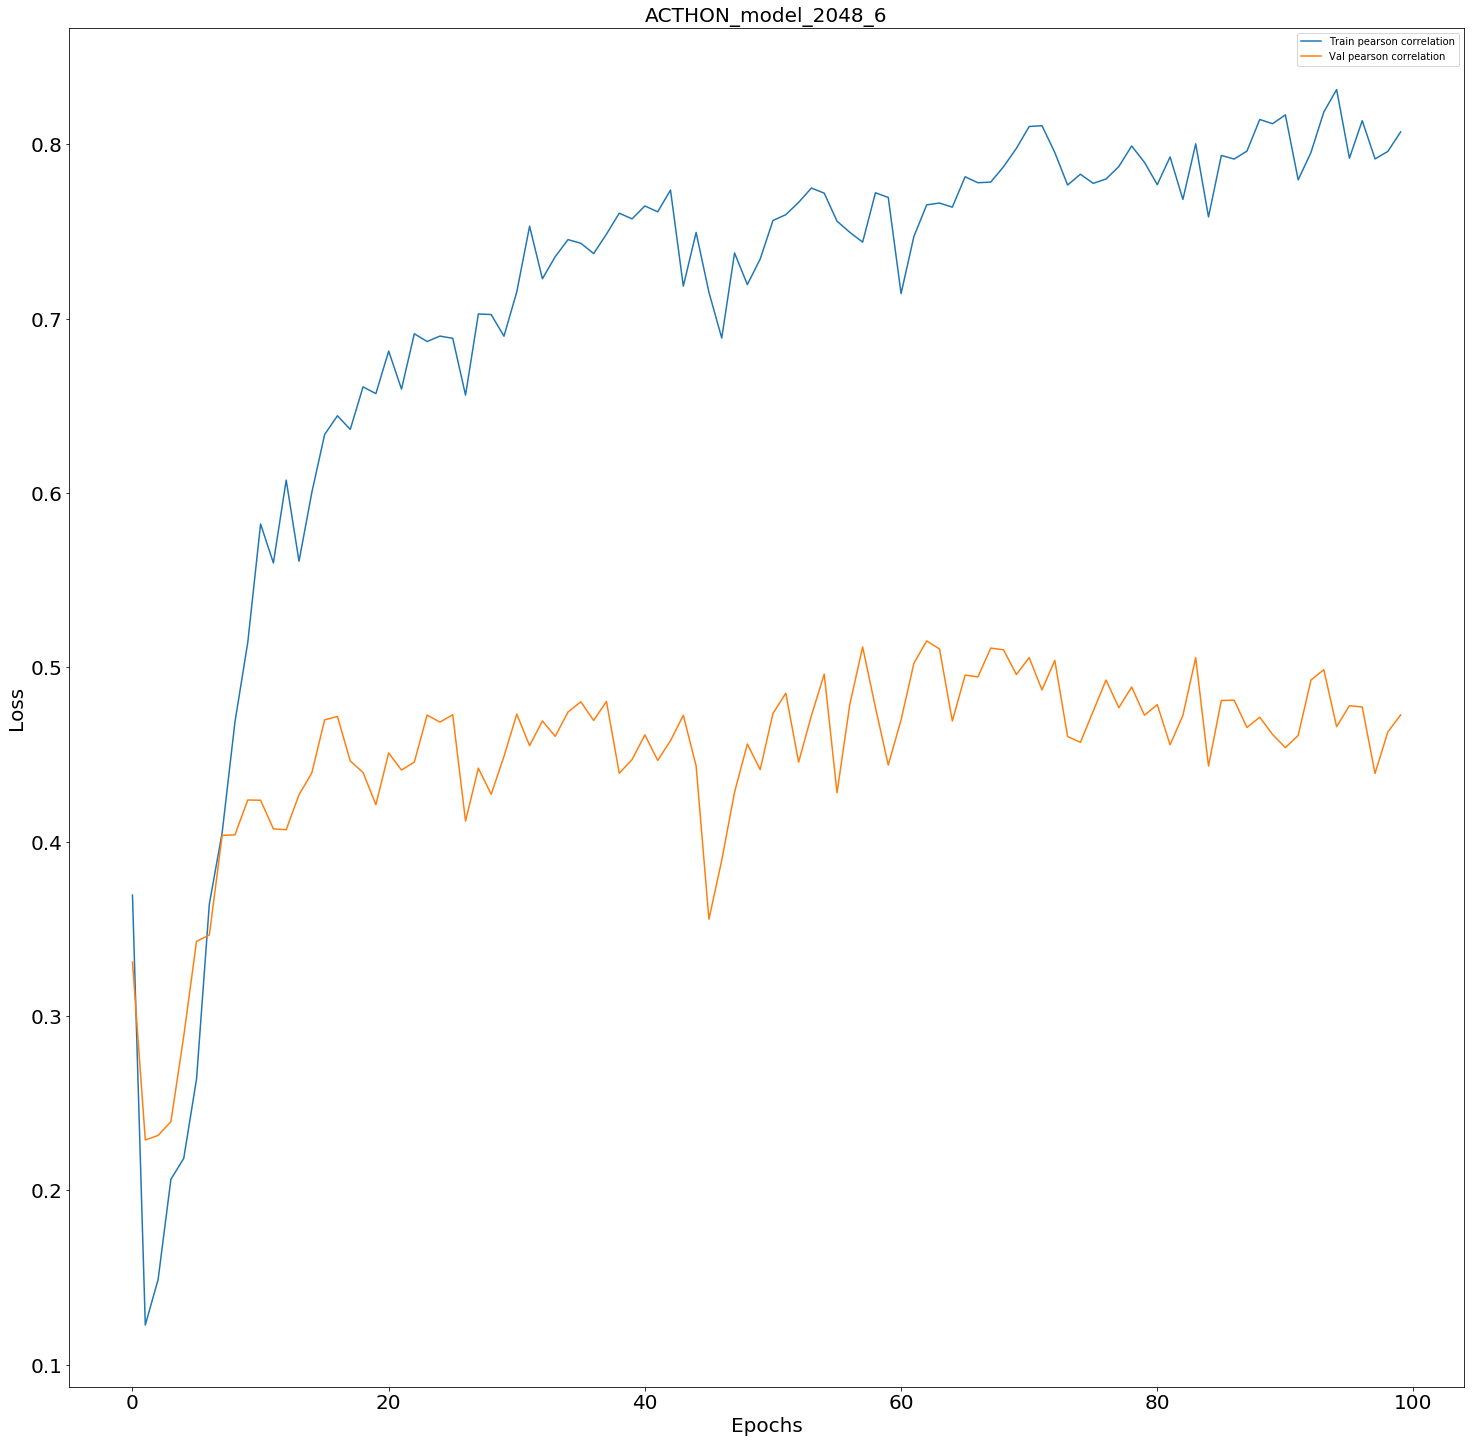

In [198]:
BIGGER_SIZE = 20
plt.figure(figsize=(25, 25))
plt.plot(historyList['pearson_r'], label='Train pearson correlation')
plt.plot(historyList['val_pearson_r'], label='Val pearson correlation')
plt.xlabel('Epochs', size=BIGGER_SIZE)
plt.ylabel('Loss', size=BIGGER_SIZE)
plt.xticks(fontsize=BIGGER_SIZE)
plt.yticks(fontsize=BIGGER_SIZE)
# plt.ylim((0.25, 0.75)) 
plt.title(model_name, size=BIGGER_SIZE)
plt.legend()

In [182]:
model.load_weights(model_name)
predict = 10**(model.predict(x_val_from_train))
true = y_val_from_train

In [195]:
print('rmse: ',rmse(true[:,2],predict[:,2]))
print('pearson: ',pearson(true[:,2],predict[:,2]))
print('spearman: ',spearman(true[:,2],predict[:,2]))
print('ci: ',ci(true[:,2],predict[:,2]))
print('f1: ',f1(true[:,2],predict[:,2]))
print('average_AUC: ',average_AUC(true[:,2],predict[:,2]))
print('accuracy: ',accuracy(true[:,2],predict[:,2]))

rmse:  8.94662382675182
pearson:  0.3622691835393527
spearman:  0.5325421875118505
ci:  0.6918396741829741
f1:  0.9162216123772023
average_AUC:  0.7166729662646987
accuracy:  0.94


C:\Users\USERA\Anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


No handles with labels found to put in legend.


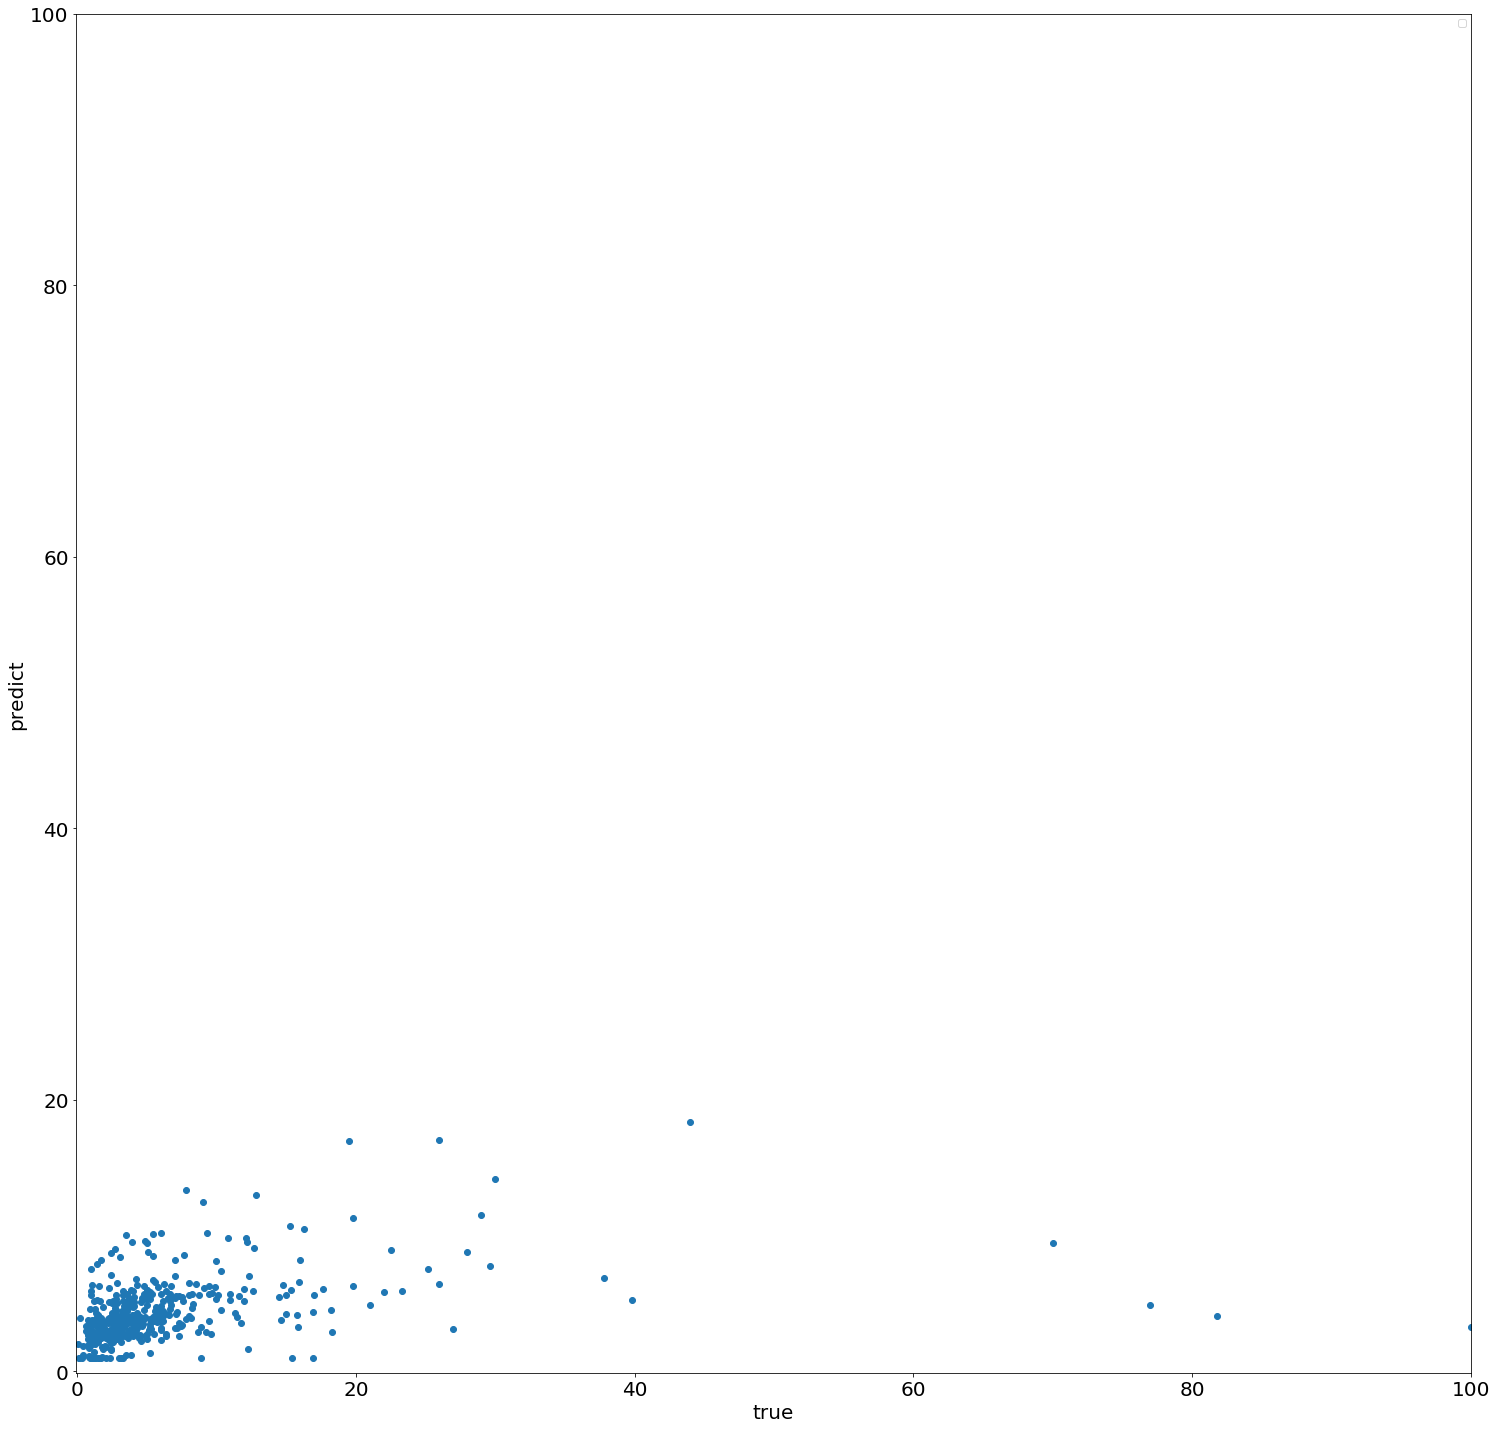

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
BIGGER_SIZE = 20
plt.figure(figsize=(25, 25))
plt.scatter(true[:,2],predict[:,2])
plt.xlabel('true', size=BIGGER_SIZE)
plt.ylabel('predict', size=BIGGER_SIZE)
plt.xticks(fontsize=BIGGER_SIZE)
plt.xlim((-0.1, 100))
plt.yticks(fontsize=BIGGER_SIZE)
plt.ylim((-0.1, 100)) 
plt.legend()
plt.show()

In [183]:
model.load_weights(model_name)
predict_train = 10**(model.predict(x_train_from_train))
true_train = y_train_from_train

In [200]:
print('rmse: ',rmse(true_train[:,2],predict_train[:,2]))
print('pearson: ',pearson(true_train[:,2],predict_train[:,2]))
print('spearman: ',spearman(true_train[:,2],predict_train[:,2]))
print('ci: ',ci(true_train[:,2],predict_train[:,2]))
print('f1: ',f1(true_train[:,2],predict_train[:,2]))
print('average_AUC: ',average_AUC(true_train[:,2],predict_train[:,2]))
print('accuracy: ',accuracy(true_train[:,2],predict_train[:,2]))

rmse:  11.273675043016594
pearson:  0.9106193253347294
spearman:  0.8795335832408122
ci:  0.860111875915142
f1:  0.9174097843704292
average_AUC:  0.9843978176134899
accuracy:  0.9398998330550918


No handles with labels found to put in legend.


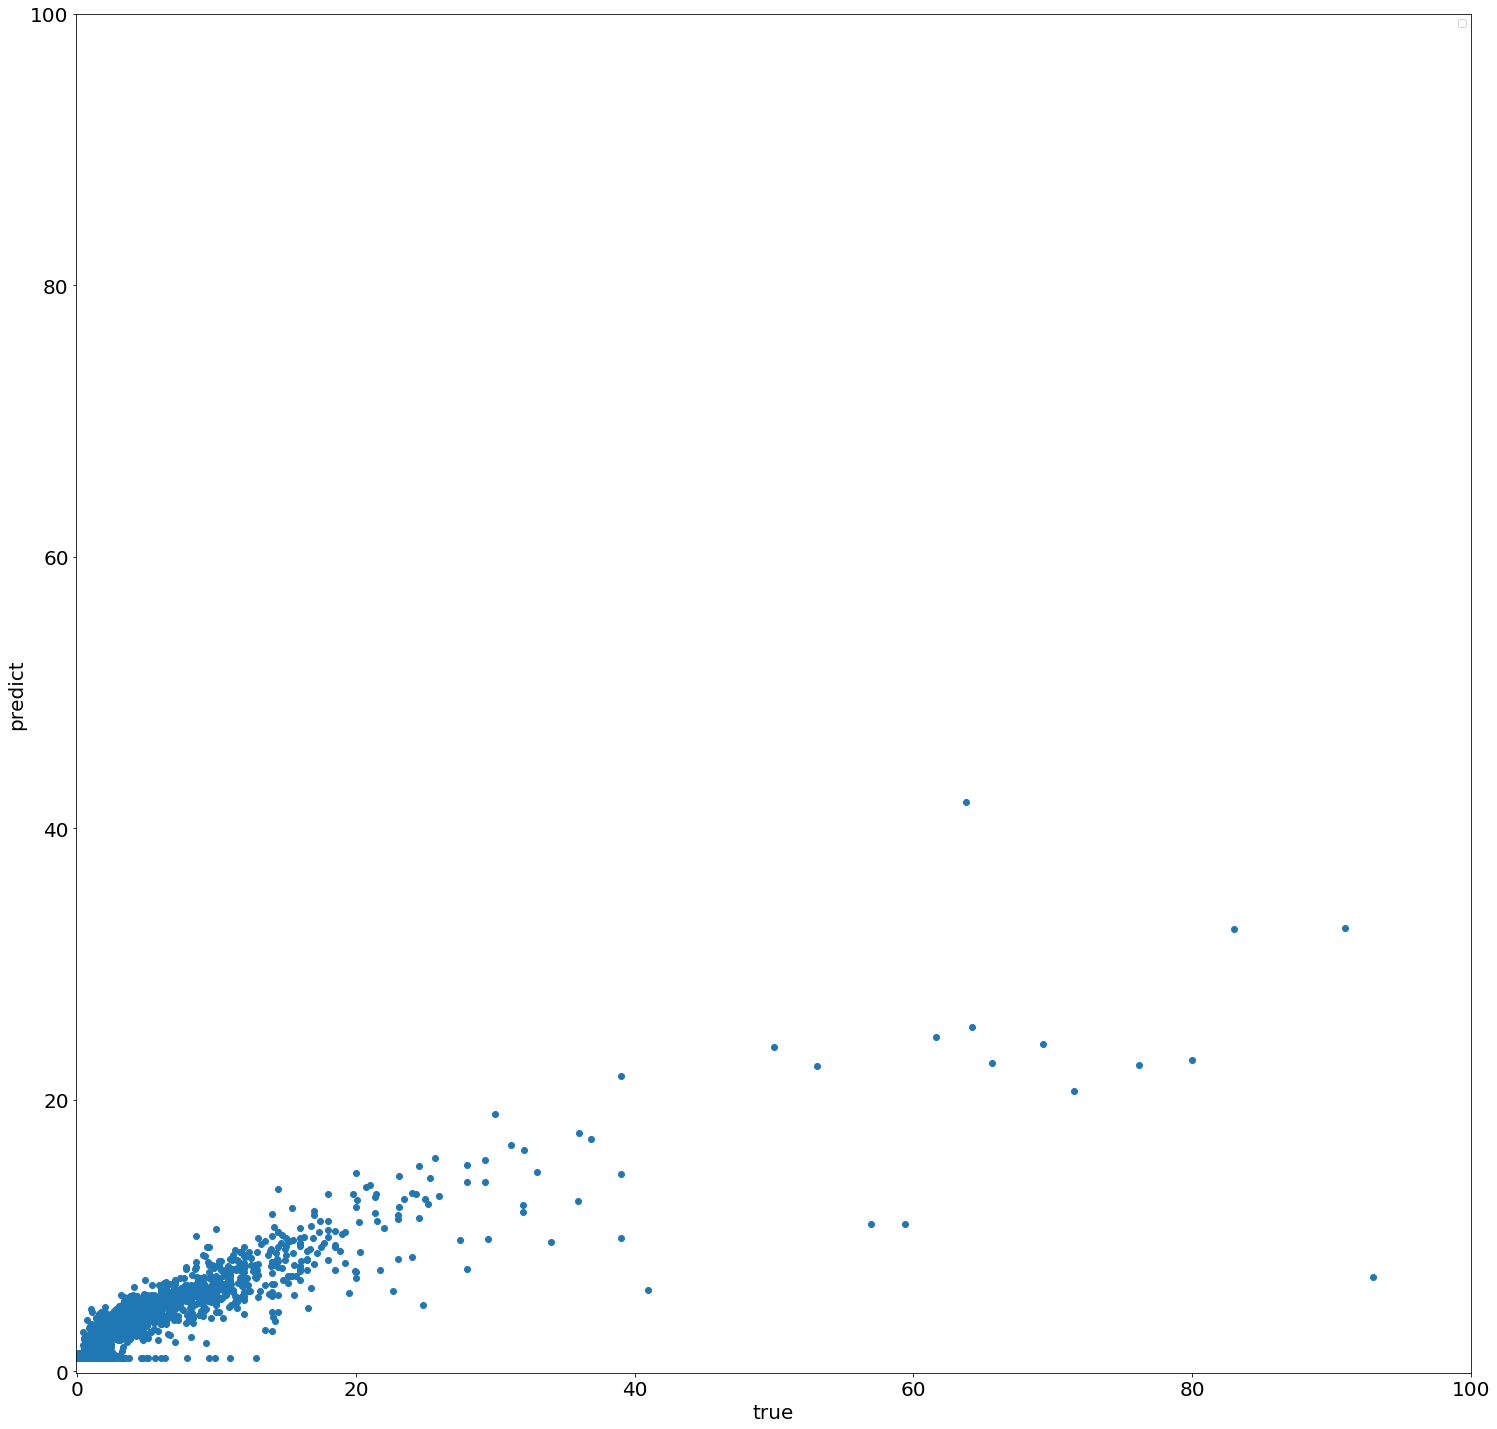

In [203]:
%matplotlib inline
import matplotlib.pyplot as plt
BIGGER_SIZE = 20
plt.figure(figsize=(25, 25))
plt.scatter(true_train[:,2],predict_train[:,2])
plt.xlabel('true', size=BIGGER_SIZE)
plt.ylabel('predict', size=BIGGER_SIZE)
plt.xticks(fontsize=BIGGER_SIZE)
plt.xlim((-0.1, 100))
plt.yticks(fontsize=BIGGER_SIZE)
plt.ylim((-0.1, 100)) 
plt.legend()
plt.show()